Importamos los módulos necesarios: 
networkx -> Para trabajar con grafos en python y poder visualizarlos
pyspark -> Para poder trabajar con rdds 

In [3]:
import networkx as nx
from tabulate import tabulate
from networkx.drawing.nx_pylab import draw
from pyspark import SparkContext
sc = SparkContext()

22/04/28 10:05:42 WARN Utils: Your hostname, gispi-ThinkPad-L380 resolves to a loopback address: 127.0.1.1; using 192.168.0.20 instead (on interface enxa0cec8f5b962)
22/04/28 10:05:42 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/04/28 10:05:42 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/04/28 10:05:43 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/04/28 10:05:43 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


Extrae un grafo del txt para poder dibujarlo

In [6]:
def read_graph(filename):
    graph = nx.Graph()
    with open(filename) as f:
        for line in f:
            graph.add_edge(*line.strip().split(','))
    return graph

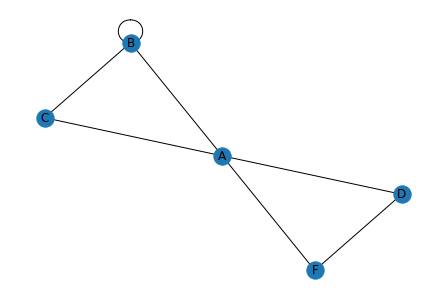

In [5]:
g = read_graph("g.txt")
draw(g, with_labels=True)

Construimos la lista de adyacencia considerando sólo los nodos posteriores

In [5]:
def get_edges(line): # grafo no dirigido, sin bucles.
    edge = line.strip().split(',')
    n1 = edge[0]
    n2 = edge[1]
    if n1 < n2:
         return (n1,n2)
    elif n1 > n2:
         return (n2,n1)
    else:
        pass #n1 == n2

def get_rdd_distict_edges(sc, filename):
    return sc.textFile(filename).\
        map(get_edges).\
        filter(lambda x: x is not None).\
        distinct()

def adjacents(sc, filename):
    nodes = get_rdd_distict_edges(sc, filename)
    adj = nodes.groupByKey().collect()
    print(adj)
    for node in adj:
        print(node[0], list(node[1]))

In [12]:
adjacents(sc,"g.txt")

[('A', <pyspark.resultiterable.ResultIterable object at 0x7fdc7c50fe50>), ('D', <pyspark.resultiterable.ResultIterable object at 0x7fdc7d205cd0>), ('B', <pyspark.resultiterable.ResultIterable object at 0x7fdc7d205ac0>)]
A ['B', 'D', 'F', 'C']
D ['F']
B ['C']


In [4]:
def adjacents_p(sc, filename):
    nodes = get_rdd_distict_edges(sc, filename)
    adj = nodes.groupByKey().collect()
    print(adj)
    lista = []
    for node in adj:
        #lista.append((node[0], list(node[1])))
        for element in list(node[1]): 
            lista.append(((node[0],element), "exists"))
    ordenados = sorted(lista, key = lambda arista : arista[0])
    #print(lista)
    print(tabulate(ordenados, headers=["Arista", "Estado"]))
    

In [7]:
adjacents_p(sc, "g.txt")

[('A', <pyspark.resultiterable.ResultIterable object at 0x7f938c10a850>), ('D', <pyspark.resultiterable.ResultIterable object at 0x7f938c10a7f0>), ('B', <pyspark.resultiterable.ResultIterable object at 0x7f938c10a8e0>)]
Arista      Estado
----------  --------
('A', 'B')  exists
('A', 'C')  exists
('A', 'D')  exists
('A', 'F')  exists
('B', 'C')  exists
('D', 'F')  exists
